In [1]:
from docplex.cp.model import CpoModel
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

# Data Creation

In [2]:
inputs = {}

Houses = pd.DataFrame([])
Houses['house']=[str(i) for i in range(1,6)]


Tasks = pd.DataFrame(\
    [   ["masonry",   35],
         ["carpentry", 15],
         ["plumbing",  40],
         ["ceiling",   15],
         ["roofing",    5],
         ["painting",  10],
         ["windows",    5],
         ["facade",    10],
         ["garden",     5],
         ["moving",     5]], columns = ["task", "duration"])



TaskPrecedence = pd.DataFrame\
                  ([["masonry",   "carpentry"],
                    ["masonry",   "plumbing"],
                    ["masonry",   "ceiling"],
                    ["carpentry", "roofing"],
                    ["ceiling",   "painting"],
                    ["roofing",   "windows"],
                    ["roofing",   "facade"],
                    ["plumbing",  "facade"],
                    ["roofing",   "garden"],
                    ["plumbing",  "garden"],
                    ["windows",   "moving"],
                    ["facade",    "moving"],
                    ["garden",    "moving"],
                    ["painting",  "moving"]], columns = ["beforeTask", "afterTask"])


Skills  =  pd.DataFrame\
        ([["Joe",  "masonry",   9],
          ["Joe",  "carpentry", 7],
          ["Joe",  "ceiling",   5],
          ["Joe",  "roofing",   6],
          ["Joe",  "windows",   8],
          ["Joe",  "facade",    5],
          ["Joe",  "garden",    5],
          ["Joe",  "moving",    6],
          ["Jack", "masonry",   5],
          ["Jack", "plumbing",  7],
          ["Jack", "ceiling",   8],
          ["Jack", "roofing",   7],
          ["Jack", "painting",  9],
          ["Jack", "facade",    5],
          ["Jack", "garden",    5],
          ["Jim",  "carpentry", 5],
          ["Jim",  "painting",  6],
          ["Jim",  "windows",   5],
          ["Jim",  "garden",    9],
          ["Jim",  "moving",    8]], columns = ["worker", "task", "level"] )
          

# Worker and continuity requirements: if the Task 1 is done on the house, he must do the task 2 in this house
Continuities = pd.DataFrame([
                ["Joe",  "masonry",   "carpentry"],
                ["Jack", "roofing",   "facade"],
                ["Joe",  "carpentry", "roofing"],
                ["Jim",  "garden",    "moving"]], columns = ["worker", "task1", "task2"])


inputs['Houses']= Houses
inputs['Tasks']= Tasks
inputs['TaskPrecedence']= TaskPrecedence
inputs['Skills']= Skills
inputs['Continuities']= Continuities

inputs.keys()

dict_keys(['Houses', 'Tasks', 'TaskPrecedence', 'Skills', 'Continuities'])

# Model Building

create model

In [3]:

mdl = CpoModel(name="HouseBuilding")

MAX_SCHEDULE = Tasks['duration'].sum()*5

Define Decision variables

In [4]:
# table of interval variable for each house and task
tasks = pd.merge(Houses, Tasks, how = 'cross')
tasks['TaskDV']=0
for index, row in tasks.iterrows():
    dv =  mdl.interval_var((0, MAX_SCHEDULE) , (0, MAX_SCHEDULE) , size=row.duration, name="house:{} task:{}".format(row.house, row.task))
    tasks.at[index, 'TaskDV']=dv

display(tasks.head())



#table of interval variable for each house and skill
wtasks = pd.merge(Houses, Skills, how = 'cross')
wtasks['SkillDV']=0
for index, row in wtasks.iterrows():
    dv =  mdl.interval_var(optional = True , name="house:{} worker:{} skill:{}".format(row.house, row.worker, row.task))
    wtasks.at[index, 'SkillDV']=dv


display(wtasks.head())

,house,task,duration,TaskDV
0,1,masonry,35,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)"
1,1,carpentry,15,"""house:1 task:carpentry"" = intervalVar(start=0..725, end=0..725, size=15)"
2,1,plumbing,40,"""house:1 task:plumbing"" = intervalVar(start=0..725, end=0..725, size=40)"
3,1,ceiling,15,"""house:1 task:ceiling"" = intervalVar(start=0..725, end=0..725, size=15)"
4,1,roofing,5,"""house:1 task:roofing"" = intervalVar(start=0..725, end=0..725, size=5)"


,house,worker,task,level,SkillDV
0,1,Joe,masonry,9,"""house:1 worker:Joe skill:masonry"" = intervalVar(optional)"
1,1,Joe,carpentry,7,"""house:1 worker:Joe skill:carpentry"" = intervalVar(optional)"
2,1,Joe,ceiling,5,"""house:1 worker:Joe skill:ceiling"" = intervalVar(optional)"
3,1,Joe,roofing,6,"""house:1 worker:Joe skill:roofing"" = intervalVar(optional)"
4,1,Joe,windows,8,"""house:1 worker:Joe skill:windows"" = intervalVar(optional)"


Define Constraints

In [5]:
# Temporal constraints.TASK_PRECEDENCES  

u = pd.merge(tasks,TaskPrecedence, left_on = 'task', right_on = 'beforeTask' )[['house', 'TaskDV', 'beforeTask','afterTask']].rename(columns = {'TaskDV':"TaskDV_before"})
v= pd.merge(u, tasks, left_on = ['afterTask','house'] , right_on = ['task','house']).rename(columns = {'TaskDV':"TaskDV_after"})[['house', 'TaskDV_before', 'beforeTask','afterTask','TaskDV_after']]
display(v.head())


for index, row in v.iterrows():
    mdl.add( mdl.end_before_start(row.TaskDV_before, row.TaskDV_after))


,house,TaskDV_before,beforeTask,afterTask,TaskDV_after
0,1,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,carpentry,"""house:1 task:carpentry"" = intervalVar(start=0..725, end=0..725, size=15)"
1,1,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,plumbing,"""house:1 task:plumbing"" = intervalVar(start=0..725, end=0..725, size=40)"
2,1,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,ceiling,"""house:1 task:ceiling"" = intervalVar(start=0..725, end=0..725, size=15)"
3,2,"""house:2 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,carpentry,"""house:2 task:carpentry"" = intervalVar(start=0..725, end=0..725, size=15)"
4,2,"""house:2 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)",masonry,plumbing,"""house:2 task:plumbing"" = intervalVar(start=0..725, end=0..725, size=40)"


In [6]:
# For each task in a house, only one of the workers should be assigned.

df = pd.merge(tasks[['house','task']], wtasks[['house','task','worker']], on = ['house','task'])

task_workers = df.groupby(['house','task']).agg(list).reset_index(drop=False)

task_workers.head()


#df = pd.merge(tasks, wtasks, on = ['house','task'])
#f= df.groupby(['house','task','duration']).agg(list)
#df['TaskDV'] = df['TaskDV'].apply(lambda x:x[0])

for row in task_workers.itertuples():      #.iloc[0:1]
    house = row.house
    task = row.task
    worker = row.worker

    task_dv = tasks[(tasks['house']==house) & (tasks['task']==task)  ]['TaskDV'].values[0]
    skills_dv = wtasks[(wtasks['house']==house) & (wtasks['task']==task)   ]['SkillDV'].values.tolist()
    #print(task_dv.name, "---->"  ,  [i.name for i in skills_dv])
    mdl.add(  mdl.alternative(task_dv, skills_dv, cardinality=1)  )

In [7]:
u = pd.merge(wtasks, Continuities, left_on = ['task', 'worker'], right_on = ['task1', 'worker'])[['house','worker','task1', 'task2','SkillDV']].\
    rename(columns ={'SkillDV':'SkillDV_1'} )

v= pd.merge(wtasks, u, left_on = ['house', 'task', 'worker'], right_on = ['house', 'task2', 'worker']).\
    rename(columns ={'SkillDV':'SkillDV_2'} )[['house','worker','task1', 'task2','SkillDV_1', 'SkillDV_2']].sort_values(['house','worker'])

display(v.head())

for row in v.itertuples(): 
    mdl.add ( mdl.presence_of ( row.SkillDV_1 )== mdl.presence_of(row.SkillDV_2))


,house,worker,task1,task2,SkillDV_1,SkillDV_2
2,1,Jack,roofing,facade,"""house:1 worker:Jack skill:roofing"" = intervalVar(optional)","""house:1 worker:Jack skill:facade"" = intervalVar(optional)"
3,1,Jim,garden,moving,"""house:1 worker:Jim skill:garden"" = intervalVar(optional)","""house:1 worker:Jim skill:moving"" = intervalVar(optional)"
0,1,Joe,masonry,carpentry,"""house:1 worker:Joe skill:masonry"" = intervalVar(optional)","""house:1 worker:Joe skill:carpentry"" = intervalVar(optional)"
1,1,Joe,carpentry,roofing,"""house:1 worker:Joe skill:carpentry"" = intervalVar(optional)","""house:1 worker:Joe skill:roofing"" = intervalVar(optional)"
6,2,Jack,roofing,facade,"""house:2 worker:Jack skill:roofing"" = intervalVar(optional)","""house:2 worker:Jack skill:facade"" = intervalVar(optional)"


In [8]:
wtasks.head(10)

,house,worker,task,level,SkillDV
0,1,Joe,masonry,9,"""house:1 worker:Joe skill:masonry"" = intervalVar(optional)"
1,1,Joe,carpentry,7,"""house:1 worker:Joe skill:carpentry"" = intervalVar(optional)"
2,1,Joe,ceiling,5,"""house:1 worker:Joe skill:ceiling"" = intervalVar(optional)"
3,1,Joe,roofing,6,"""house:1 worker:Joe skill:roofing"" = intervalVar(optional)"
4,1,Joe,windows,8,"""house:1 worker:Joe skill:windows"" = intervalVar(optional)"
5,1,Joe,facade,5,"""house:1 worker:Joe skill:facade"" = intervalVar(optional)"
6,1,Joe,garden,5,"""house:1 worker:Joe skill:garden"" = intervalVar(optional)"
7,1,Joe,moving,6,"""house:1 worker:Joe skill:moving"" = intervalVar(optional)"
8,1,Jack,masonry,5,"""house:1 worker:Jack skill:masonry"" = intervalVar(optional)"
9,1,Jack,plumbing,7,"""house:1 worker:Jack skill:plumbing"" = intervalVar(optional)"


In [9]:
# No overlap constraint

workers_per_house = wtasks[['house','worker','SkillDV' ]].groupby(['house','worker']).agg(list)
display(workers_per_house.head(2))

for row in workers_per_house.itertuples():
    mdl.add ( mdl.no_overlap( row.SkillDV)) 


SkillDV
house worker                                                                                                                                                                                                                                                                                                                                                                                                                                             
1     Jack    ["house:1 worker:Jack skill:masonry" = intervalVar(optional), "house:1 worker:Jack skill:plumbing" = intervalVar(optional), "house:1 worker:Jack skill:ceiling" = intervalVar(optional), "house:1 worker:Jack skill:roofing" = intervalVar(optional), "house:1 worker:Jack skill:painting" = intervalVar(optional), "house:1 worker:Jack skill:facade" = intervalVar(optional), "house:1 worker:Jack skill:garden" = intervalVar(optional)]
      Jim                                                                                                                                   ["house:1 worker:Jim skill:carpentry" = intervalVar(optional), "house:1 worker:Jim skill:painting" = intervalVar(optional), "house:1 worker:Jim skill:windows" = intervalVar(optional), "house:1 worker:Jim skill:garden" = intervalVar(optional), "house:1 worker:Jim skill:moving" = intervalVar(optional)]

# Solve

In [10]:
print("\nSolving model....")
msol = mdl.solve(TimeLimit=20, trace_log=False)

# Print solution
print("Solve status: " + msol.get_solve_status())



Solving model....
Solve status: Feasible


In [11]:
tasks['TaskDV_sol'] = tasks['TaskDV'].apply(lambda x:msol.get_var_solution(x))
tasks

,house,task,duration,TaskDV,TaskDV_sol
0,1,masonry,35,"""house:1 task:masonry"" = intervalVar(start=0..725, end=0..725, size=35)","house:1 task:masonry: (start=0, end=35, size=35, length=35)"
1,1,carpentry,15,"""house:1 task:carpentry"" = intervalVar(start=0..725, end=0..725, size=15)","house:1 task:carpentry: (start=35, end=50, size=15, length=15)"
2,1,plumbing,40,"""house:1 task:plumbing"" = intervalVar(start=0..725, end=0..725, size=40)","house:1 task:plumbing: (start=35, end=75, size=40, length=40)"
3,1,ceiling,15,"""house:1 task:ceiling"" = intervalVar(start=0..725, end=0..725, size=15)","house:1 task:ceiling: (start=35, end=50, size=15, length=15)"
4,1,roofing,5,"""house:1 task:roofing"" = intervalVar(start=0..725, end=0..725, size=5)","house:1 task:roofing: (start=75, end=80, size=5, length=5)"
5,1,painting,10,"""house:1 task:painting"" = intervalVar(start=0..725, end=0..725, size=10)","house:1 task:painting: (start=50, end=60, size=10, length=10)"
6,1,windows,5,"""house:1 task:windows"" = intervalVar(start=0..725, end=0..725, size=5)","house:1 task:windows: (start=80, end=85, size=5, length=5)"
7,1,facade,10,"""house:1 task:facade"" = intervalVar(start=0..725, end=0..725, size=10)","house:1 task:facade: (start=80, end=90, size=10, length=10)"
8,1,garden,5,"""house:1 task:garden"" = intervalVar(start=0..725, end=0..725, size=5)","house:1 task:garden: (start=80, end=85, size=5, length=5)"
9,1,moving,5,"""house:1 task:moving"" = intervalVar(start=0..725, end=0..725, size=5)","house:1 task:moving: (start=90, end=95, size=5, length=5)"


In [12]:
wtasks['SkillDV_sol'] = wtasks['SkillDV'].apply(lambda x:msol.get_var_solution(x))
wtasks.sort_values('task')

,house,worker,task,level,SkillDV,SkillDV_sol
35,2,Jim,carpentry,5,"""house:2 worker:Jim skill:carpentry"" = intervalVar(optional)","house:2 worker:Jim skill:carpentry: (start=35, end=50, size=15, length=15)"
81,5,Joe,carpentry,7,"""house:5 worker:Joe skill:carpentry"" = intervalVar(optional)",house:5 worker:Joe skill:carpentry: absent
15,1,Jim,carpentry,5,"""house:1 worker:Jim skill:carpentry"" = intervalVar(optional)","house:1 worker:Jim skill:carpentry: (start=35, end=50, size=15, length=15)"
41,3,Joe,carpentry,7,"""house:3 worker:Joe skill:carpentry"" = intervalVar(optional)",house:3 worker:Joe skill:carpentry: absent
21,2,Joe,carpentry,7,"""house:2 worker:Joe skill:carpentry"" = intervalVar(optional)",house:2 worker:Joe skill:carpentry: absent
75,4,Jim,carpentry,5,"""house:4 worker:Jim skill:carpentry"" = intervalVar(optional)","house:4 worker:Jim skill:carpentry: (start=35, end=50, size=15, length=15)"
61,4,Joe,carpentry,7,"""house:4 worker:Joe skill:carpentry"" = intervalVar(optional)",house:4 worker:Joe skill:carpentry: absent
55,3,Jim,carpentry,5,"""house:3 worker:Jim skill:carpentry"" = intervalVar(optional)","house:3 worker:Jim skill:carpentry: (start=35, end=50, size=15, length=15)"
95,5,Jim,carpentry,5,"""house:5 worker:Jim skill:carpentry"" = intervalVar(optional)","house:5 worker:Jim skill:carpentry: (start=35, end=50, size=15, length=15)"
1,1,Joe,carpentry,7,"""house:1 worker:Joe skill:carpentry"" = intervalVar(optional)",house:1 worker:Joe skill:carpentry: absent


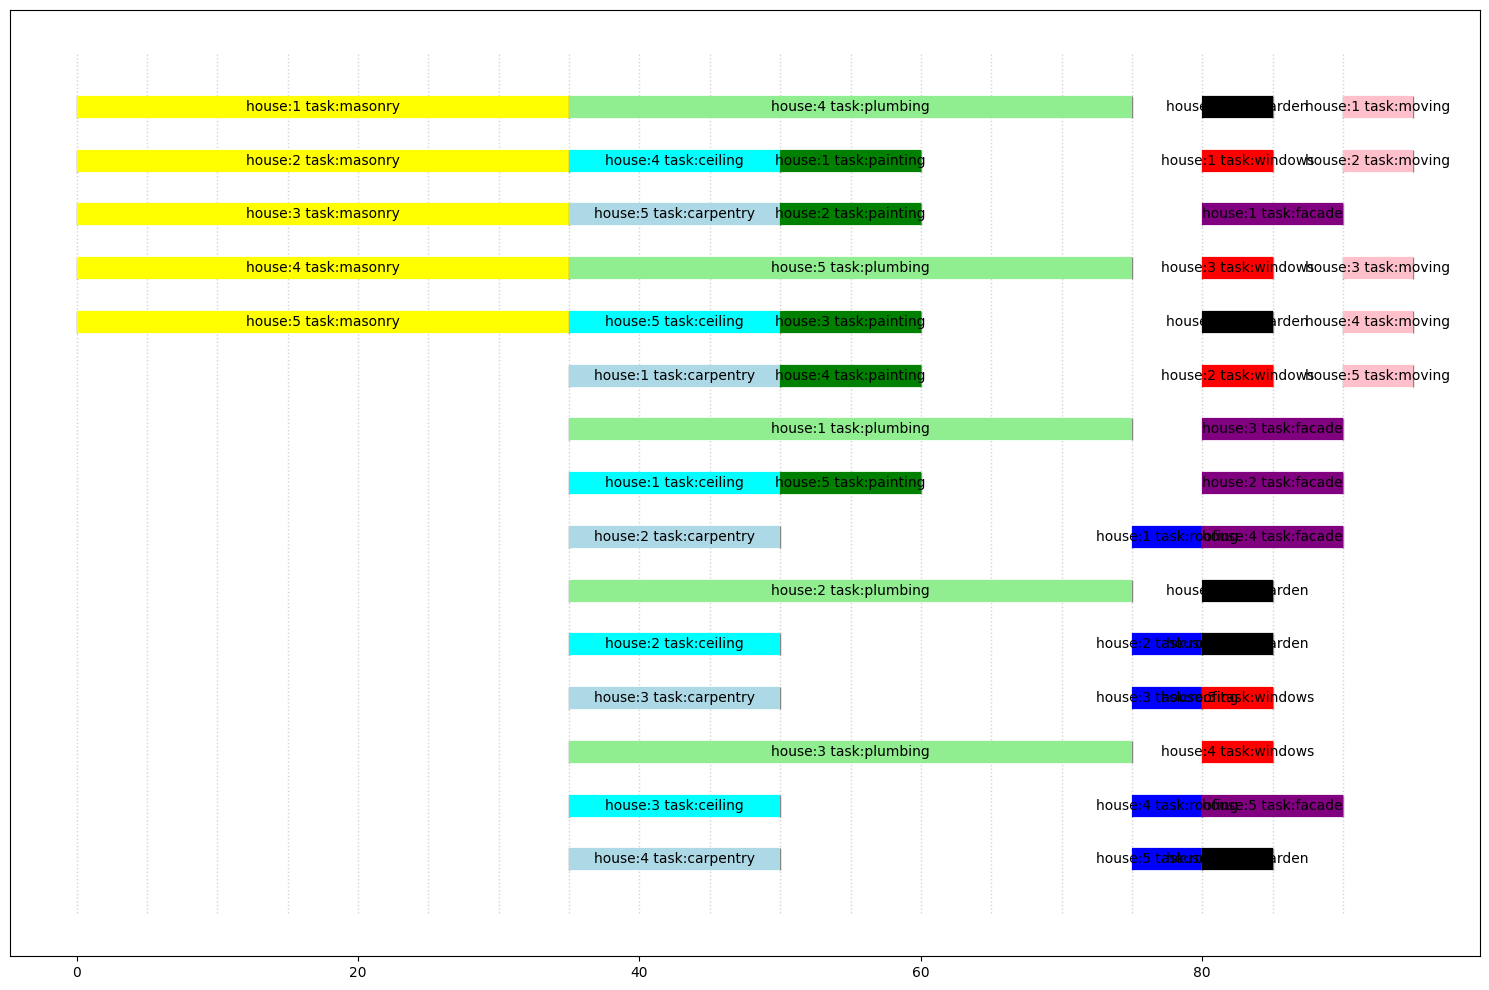

In [13]:
POP_UP_GRAPHIC=False
import docplex.cp.utils_visu as visu

colors ={"masonry":'yellow',   "carpentry":'lightblue', "plumbing":  'lightgreen',"ceiling" :'cyan' ,"roofing":'blue',"painting":'green',"windows":'red',"facade":  'purple',"garden":'black',"moving":
 'pink'}

for i in tasks['TaskDV'].values:
    var_sol = msol.get_var_solution(i)
    task_id = i.name.split(':')[-1]
    #visu.panel()
    visu.interval(var_sol, colors[task_id], i.name)  
visu.show()